In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, initializers

import warnings
warnings.filterwarnings("ignore")

import BjerksundStenslandModel as BS
from EnsembleNeuralNetworks import ENN
# from BlackScholesModel.py import black_scholes_call_option, black_scholes_put_option

In [2]:
# Read the data
df = pd.read_csv('/Users/gaojinglun/Desktop/RSG/data/ES_EZ.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Put.Call,Strike.Price,Settlement,Historical Vol,futures.price,Time.to.maturity,Risk.Free.Rate,Open.Interest,Implied.Volatility,Moneyness
0,C,2200,1059.0,0.008335,3259.0,0.213699,0.0154,826.0,0.338267,ITM
1,C,2250,1009.1,0.008335,3259.0,0.213699,0.0154,728.0,0.326829,ITM
2,C,2270,989.1,0.008335,3259.0,0.213699,0.0154,1.0,0.323456,ITM
3,C,2300,959.2,0.008335,3259.0,0.213699,0.0154,212.0,0.317834,ITM
4,C,2310,949.2,0.008335,3259.0,0.213699,0.0154,42.0,0.314282,ITM


In [3]:
# Set the number of estimators in the ensemble learning
n_estimators = 10

Xcol = ['futures.price', 'Strike.Price', 'Time.to.maturity']
Ycol = 'Implied.Volatility'

### Call Options

In [4]:
ES_EZ_call = df[df['Put.Call'] == 'C']

Call_temp = 100 * ES_EZ_call['Strike.Price'].values / ES_EZ_call['futures.price'].values
Call_ITM_idx = Call_temp < 95.2
Call_ATM_idx = np.logical_and(Call_temp <= 103.1, Call_temp >= 95.2)
Call_OTM_idx = Call_temp > 103.1

Call_moneyness = pd.get_dummies(ES_EZ_call['Moneyness'])
ES_EZ_call = pd.concat([ES_EZ_call, Call_moneyness], axis = 1)

In [5]:
ENN_Call = ENN(n_estimators = n_estimators, inputShape = 9)
ENN_Call.bootstrap(data = ES_EZ_call, 
                   stratification = ES_EZ_call['Moneyness'], trainsize = 0.8)
LR = [1e-2, 1e-3]
ENN_Call.fit(LR, Xcol, Ycol)

In [6]:
ENN_Call.get_results()

The training R^2 for model 0 is 0.9006 and 0.8975, respectively
The training R^2 for model 1 is 0.9084 and 0.9097, respectively
The training R^2 for model 2 is 0.8711 and 0.8732, respectively
The training R^2 for model 3 is 0.8959 and 0.889, respectively
The training R^2 for model 4 is 0.8851 and 0.8849, respectively
The training R^2 for model 5 is 0.8899 and 0.8939, respectively
The training R^2 for model 6 is 0.9072 and 0.8984, respectively
The training R^2 for model 7 is 0.8588 and 0.8571, respectively
The training R^2 for model 8 is 0.8661 and 0.866, respectively
The training R^2 for model 9 is 0.8094 and 0.8181, respectively


In [7]:
print('The training R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_Call.results[:,0]), 4), 
                                                          np.round(np.std(ENN_Call.results[:,0]), 4)))
print('The testing R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_Call.results[:,1]), 4), 
                                                          np.round(np.std(ENN_Call.results[:,1]), 4)))

The training R^2 for call option is 0.8792 +/- 0.0284.
The testing R^2 for call option is 0.8788 +/- 0.0253.


In [8]:
ENN_Call.results

array([[0.9006, 0.8975],
       [0.9084, 0.9097],
       [0.8711, 0.8732],
       [0.8959, 0.889 ],
       [0.8851, 0.8849],
       [0.8899, 0.8939],
       [0.9072, 0.8984],
       [0.8588, 0.8571],
       [0.8661, 0.866 ],
       [0.8094, 0.8181]])

In [9]:
ES_EZ_call_X = ES_EZ_call[Xcol]
ES_EZ_call_y = ES_EZ_call[Ycol]

scalerX_call = MinMaxScaler().fit(ES_EZ_call_X)
ES_EZ_call_X = pd.DataFrame(scalerX_call.transform(ES_EZ_call_X), columns = ES_EZ_call_X.columns.values) 
scalery_call = MinMaxScaler().fit(ES_EZ_call_y.values.reshape(-1, 1))
ES_EZ_call_y = scalery_call.transform(ES_EZ_call_y.values.reshape(-1, 1))

In [10]:
result1 = np.round(r2_score(ES_EZ_call_y, ENN_Call.predict(ES_EZ_call_X)), 4)
print('The total variance of call option impied volatility explained by the model is {}.'.format(result1))

The total variance of call option impied volatility explained by the model is 0.8946.


### Put Options

In [11]:
ES_EZ_put = df[df['Put.Call'] == 'P']

Put_temp = 100 * ES_EZ_put['Strike.Price'].values / ES_EZ_put['futures.price'].values
Put_ITM_idx = Put_temp > 103
Put_ATM_idx = np.logical_and(Put_temp < 103, Put_temp >= 95.2)
Put_OTM_idx = Put_temp < 95.2

put_moneyness = pd.get_dummies(ES_EZ_put['Moneyness'])
ES_EZ_put = pd.concat([ES_EZ_put, put_moneyness], axis = 1)

In [12]:
ES_EZ_put_X = ES_EZ_put[Xcol]
ES_EZ_put_y = ES_EZ_put[Ycol]

In [13]:
ENN_Put = ENN(n_estimators = n_estimators, inputShape = 9)
ENN_Put.bootstrap(data = ES_EZ_put, stratification = ES_EZ_put['Moneyness'], trainsize = 0.8)
LR = [1e-2, 1e-3]
ENN_Put.fit(LR, Xcol, Ycol)

In [14]:
ENN_Put.get_results()

The training R^2 for model 0 is 0.9102 and 0.9114, respectively
The training R^2 for model 1 is 0.8803 and 0.8885, respectively
The training R^2 for model 2 is 0.9213 and 0.9166, respectively
The training R^2 for model 3 is 0.9129 and 0.9136, respectively
The training R^2 for model 4 is 0.9096 and 0.9104, respectively
The training R^2 for model 5 is 0.9176 and 0.9105, respectively
The training R^2 for model 6 is 0.8961 and 0.896, respectively
The training R^2 for model 7 is 0.9065 and 0.9064, respectively
The training R^2 for model 8 is 0.8948 and 0.8924, respectively
The training R^2 for model 9 is 0.9068 and 0.9061, respectively


In [15]:
print('The training R^2 for put option is {} +/- {}.'.format(np.round(np.mean(ENN_Put.results[:,0]), 4), 
                                                          np.round(np.std(ENN_Put.results[:,0]), 4)))
print('The testing R^2 for put option is {} +/- {}.'.format(np.round(np.mean(ENN_Put.results[:,1]), 4), 
                                                          np.round(np.std(ENN_Put.results[:,1]), 4)))

The training R^2 for put option is 0.9056 +/- 0.0115.
The testing R^2 for put option is 0.9052 +/- 0.0091.


In [16]:
ENN_Put.results

array([[0.9102, 0.9114],
       [0.8803, 0.8885],
       [0.9213, 0.9166],
       [0.9129, 0.9136],
       [0.9096, 0.9104],
       [0.9176, 0.9105],
       [0.8961, 0.896 ],
       [0.9065, 0.9064],
       [0.8948, 0.8924],
       [0.9068, 0.9061]])

In [17]:
scalerX_put = MinMaxScaler().fit(ES_EZ_put_X)
ES_EZ_put_X = pd.DataFrame(scalerX_put.transform(ES_EZ_put_X), columns = ES_EZ_put_X.columns.values) 

scalery_put = MinMaxScaler().fit(ES_EZ_put_y.values.reshape(-1, 1))
ES_EZ_put_y = scalery_put.transform(ES_EZ_put_y.values.reshape(-1, 1))

In [18]:
result2 = np.round(r2_score(ES_EZ_put_y, ENN_Put.predict(ES_EZ_put_X)), 4)
print('The total variance of put option impied volatility explained by the model is {}.'.format(result2))

The total variance of put option impied volatility explained by the model is 0.9195.


In [19]:
Call_ITM = ES_EZ_call['Settlement'][Call_ITM_idx]
Call_ATM = ES_EZ_call['Settlement'][Call_ATM_idx]
Call_OTM = ES_EZ_call['Settlement'][Call_OTM_idx]
Call_ALL = ES_EZ_call['Settlement']

Put_ITM = ES_EZ_put['Settlement'][Put_ITM_idx]
Put_ATM = ES_EZ_put['Settlement'][Put_ATM_idx]
Put_OTM = ES_EZ_put['Settlement'][Put_OTM_idx]
Put_ALL = ES_EZ_put['Settlement']

def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100* np.mean(np.abs((y_true - y_pred) / y_true))

def Call_Results(Call_Pred):
    '''
    Get the results for Call options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE 
    '''
    result = np.array([
        r2_score(Call_ITM, Call_Pred[Call_ITM_idx]),
        r2_score(Call_ATM, Call_Pred[Call_ATM_idx]),
        r2_score(Call_OTM, Call_Pred[Call_OTM_idx]),
        r2_score(Call_ALL, Call_Pred),
        
        mean_absolute_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_error(Call_ALL, Call_Pred),
        
        mean_absolute_percentage_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_percentage_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_percentage_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_percentage_error(Call_ALL, Call_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_call, x = np.abs(Call_ALL - Call_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_call, x = np.abs((Call_ALL - Call_Pred) / Call_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

def Put_Results(Put_Pred):
    '''
    Get the results for Put options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE
    '''

    result = np.array([
        r2_score(Put_ITM, Put_Pred[Put_ITM_idx]),
        r2_score(Put_ATM, Put_Pred[Put_ATM_idx]),
        r2_score(Put_OTM, Put_Pred[Put_OTM_idx]),
        r2_score(Put_ALL, Put_Pred),
        
        mean_absolute_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_error(Put_ALL, Put_Pred),
        
        mean_absolute_percentage_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_percentage_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_percentage_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_percentage_error(Put_ALL, Put_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_put, x = np.abs(Put_ALL - Put_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_put, x = np.abs((Put_ALL - Put_Pred) / Put_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

In [20]:
ENN_call = scalery_call.inverse_transform(ENN_Call.predict(ES_EZ_call_X))
ENN_put = scalery_put.inverse_transform(ENN_Put.predict(ES_EZ_put_X))

### Results

In [21]:
# Test the performances of ENN 
ENN_Call_Pred = np.zeros(ES_EZ_call.shape[0])
for i in range(ES_EZ_call.shape[0]):
    price = BS._american_option(option_type = 'c', 
                             fs = ES_EZ_call['futures.price'].values[i], 
                             x = ES_EZ_call['Strike.Price'].values[i], 
                             t = ES_EZ_call['Time.to.maturity'].values[i], 
                             r = ES_EZ_call['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_call[i])[0]
    ENN_Call_Pred[i] = price

ENN_PUT_Pred = np.zeros(ES_EZ_put.shape[0])
for i in range(ES_EZ_put.shape[0]):
    price = BS._american_option(option_type = 'p', 
                             fs = ES_EZ_put['futures.price'].values[i], 
                             x = ES_EZ_put['Strike.Price'].values[i], 
                             t = ES_EZ_put['Time.to.maturity'].values[i], 
                             r = ES_EZ_put['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_put[i])[0]
    ENN_PUT_Pred[i] = price


print('The total variance explained is {} for the Call Options'.format(
    np.round(r2_score(ES_EZ_call['Settlement'], ENN_Call_Pred), 5))
     )
print('The total variance explained is {} for the Put Options'.format(
    np.round(r2_score(ES_EZ_put['Settlement'], ENN_PUT_Pred), 5))
     )

The total variance explained is 0.99783 for the Call Options
The total variance explained is 0.98893 for the Put Options


The R^2 for ITM, ATM, OTM, and overall Call Option is 0.99807, 0.89978, 0.87859, and 0.99783, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Call Option is 9.67811, 21.47625, 10.83044, and 12.07973, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Call Option is 2.0942, 19.37089, 112.77068, and 39.83091, respectively.
--------------------------------------------------------------------------------------------------------


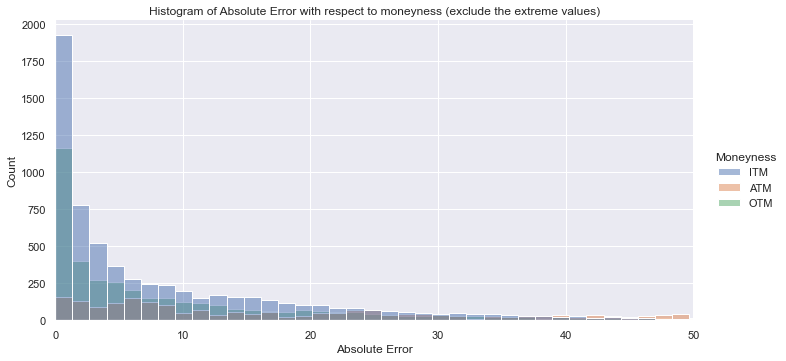

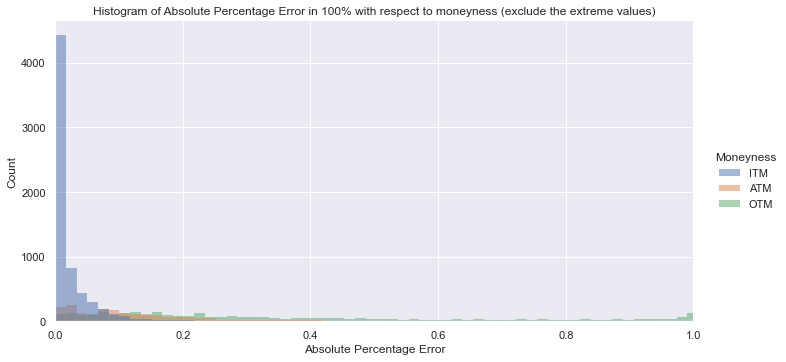

In [22]:
Call_Results(ENN_Call_Pred)

In [23]:
MAE_idx = np.argmax(np.abs(Call_ALL - ENN_Call_Pred))
print(ES_EZ_call.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAE_idx], 4))

Put.Call                       C
Strike.Price                3400
Settlement                 119.7
Historical Vol        0.00734855
futures.price             3293.3
Time.to.maturity        0.926027
Risk.Free.Rate            0.0154
Open.Interest               1656
Implied.Volatility      0.130421
Moneyness                    OTM
ATM                            0
ITM                            0
OTM                            1
Name: 596, dtype: object
--------------------------------
The predicted value is 201.5927


In [24]:
MAPE_idx = np.argmax(np.abs((Call_ALL - ENN_Call_Pred) / Call_ALL))
print(ES_EZ_call.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAPE_idx], 4))

Put.Call                      C
Strike.Price               3680
Settlement                  0.1
Historical Vol         0.015363
futures.price            3380.9
Time.to.maturity      0.0958904
Risk.Free.Rate            0.016
Open.Interest                 3
Implied.Volatility    0.0983773
Moneyness                   OTM
ATM                           0
ITM                           0
OTM                           1
Name: 1082, dtype: object
--------------------------------
The predicted value is 4.836


The R^2 for ITM, ATM, OTM, and overall Put Option is 0.9908, 0.87791, 0.89514, and 0.98893, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Put Option is 11.32856, 20.82716, 9.72206, and 11.73506, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Put Option is 3.68724, 19.02756, 55.10202, and 39.22451, respectively.
--------------------------------------------------------------------------------------------------------


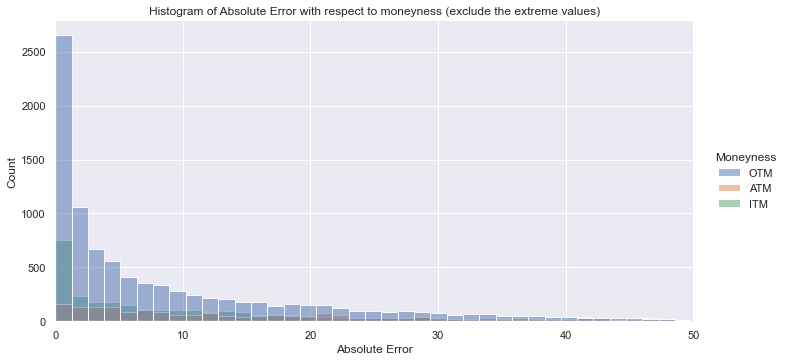

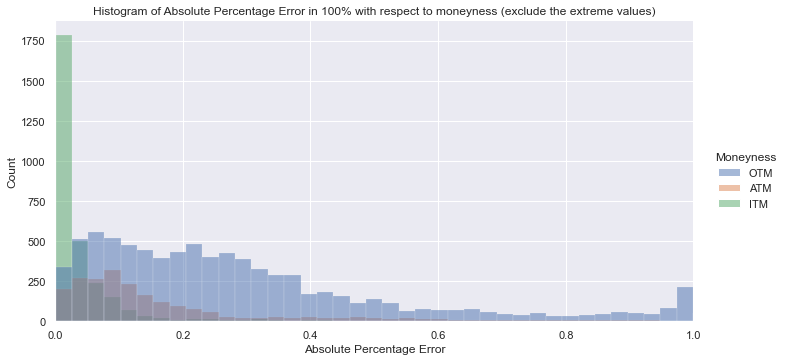

In [25]:
Put_Results(ENN_PUT_Pred)

In [26]:
MAE_idx = np.argmax(np.abs(Put_ALL - ENN_PUT_Pred))
print(ES_EZ_put.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAE_idx], 4))

Put.Call                       P
Strike.Price                3450
Settlement                   250
Historical Vol        0.00734855
futures.price             3293.3
Time.to.maturity        0.926027
Risk.Free.Rate            0.0154
Open.Interest               1198
Implied.Volatility      0.124606
Moneyness                    ITM
ATM                            0
ITM                            1
OTM                            0
Name: 13522, dtype: object
--------------------------------
The predicted value is 336.8952


In [27]:
MAPE_idx = np.argmax(np.abs((Put_ALL - ENN_PUT_Pred) / Put_ALL))
print(ES_EZ_put.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAPE_idx], 4))

Put.Call                       P
Strike.Price                1400
Settlement                  0.05
Historical Vol        0.00833466
futures.price               3259
Time.to.maturity        0.213699
Risk.Free.Rate            0.0154
Open.Interest               2519
Implied.Volatility       0.53764
Moneyness                    OTM
ATM                            0
ITM                            0
OTM                            1
Name: 12794, dtype: object
--------------------------------
The predicted value is 0.5588


In [31]:
BS_Call_Pred = np.zeros(ES_EZ_call.shape[0])
for i in range(ES_EZ_call.shape[0]):
    price = BS._american_option(option_type = 'c', 
                             fs = ES_EZ_call['futures.price'].values[i], 
                             x = ES_EZ_call['Strike.Price'].values[i], 
                             t = ES_EZ_call['Time.to.maturity'].values[i], 
                             r = ES_EZ_call['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ES_EZ_call['Implied.Volatility'].values[i])[0]
    BS_Call_Pred[i] = price

BS_PUT_Pred = np.zeros(ES_EZ_put.shape[0])
for i in range(ES_EZ_put.shape[0]):
    price = BS._american_option(option_type = 'p', 
                             fs = ES_EZ_put['futures.price'].values[i], 
                             x = ES_EZ_put['Strike.Price'].values[i], 
                             t = ES_EZ_put['Time.to.maturity'].values[i], 
                             r = ES_EZ_put['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ES_EZ_put['Implied.Volatility'].values[i])[0]
    BS_PUT_Pred[i] = price

The R^2 for ITM, ATM, OTM, and overall Call Option is 0.99999, 0.99978, 0.99965, and 0.99999, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Call Option is 0.75494, 1.1564, 0.46216, and 0.73242, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Call Option is 0.15009, 2.24316, 8.24484, and 3.05352, respectively.
--------------------------------------------------------------------------------------------------------


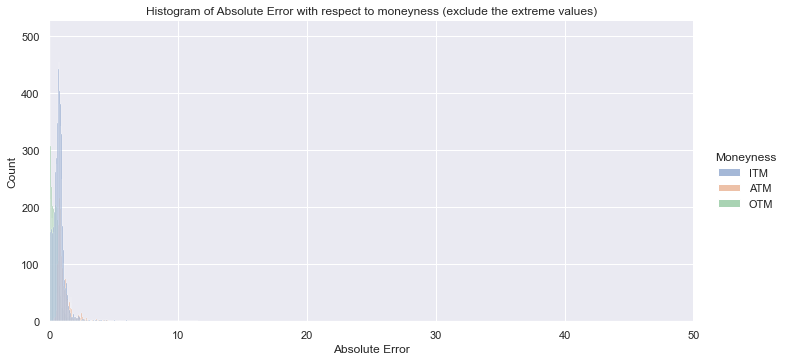

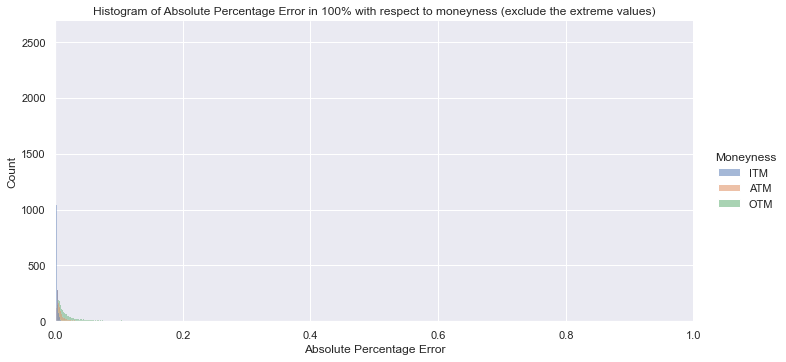

In [32]:
Call_Results(BS_Call_Pred)

The R^2 for ITM, ATM, OTM, and overall Put Option is 0.99996, 0.99974, 0.99984, and 0.99997, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Put Option is 0.69071, 1.14904, 0.49634, and 0.63486, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Put Option is 0.24128, 3.12169, 8.83467, and 6.22903, respectively.
--------------------------------------------------------------------------------------------------------


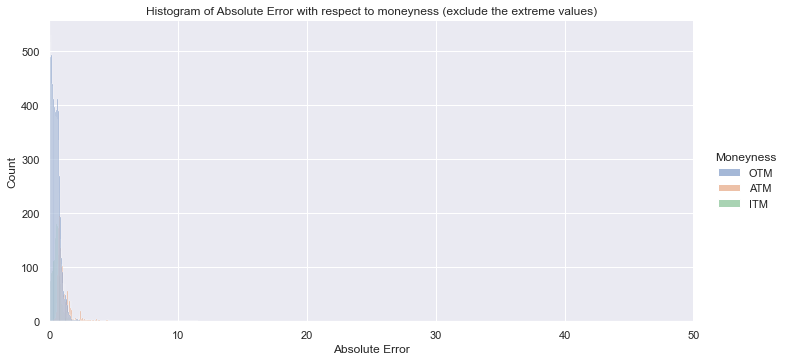

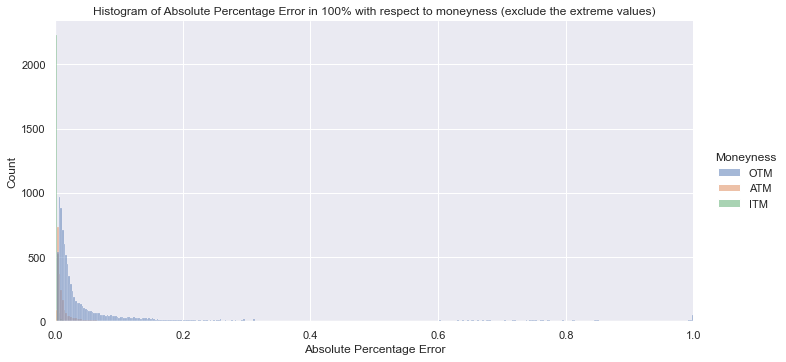

In [30]:
Put_Results(BS_PUT_Pred)